In [1]:
%matplotlib inline

from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

import tensorflow as tf
import keras.backend as K

import keras
from keras.engine.input_layer import Input

import matplotlib.pyplot as plt
import seaborn as sns

import random, os, sys
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer

pd.set_option('precision', 30)
np.set_printoptions(precision = 30)

np.random.seed(368)
tf.set_random_seed(368)

Using TensorFlow backend.


In [2]:
DATA = Path('../../Data')

In [3]:
%time train_df = pd.read_csv(DATA/'train.csv', dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32})

Wall time: 3min 6s


In [4]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.46909999847412109375
1,6,1.46909999847412109375
2,8,1.46909999847412109375
3,5,1.46909999847412109375
4,8,1.46909999847412109375


In [5]:
X_train = train_df.acoustic_data.values
y_train = train_df.time_to_failure.values

Find complete segments in the training data (time to failure goes to zero)

In [6]:
ends_mask = np.less(y_train[:-1], y_train[1:])
segment_ends = np.nonzero(ends_mask)

train_segments = []
start = 0
for end in segment_ends[0]:
    train_segments.append((start, end))
    start = end
    
print(train_segments)

[(0, 5656573), (5656573, 50085877), (50085877, 104677355), (104677355, 138772452), (138772452, 187641819), (187641819, 218652629), (218652629, 245829584), (245829584, 307838916), (307838916, 338276286), (338276286, 375377847), (375377847, 419368879), (419368879, 461811622), (461811622, 495800224), (495800224, 528777114), (528777114, 585568143), (585568143, 621985672)]


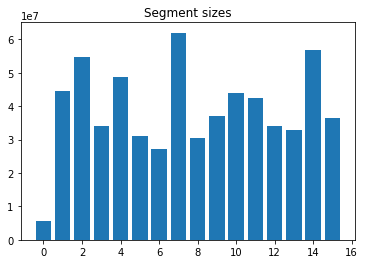

In [7]:
plt.title('Segment sizes')
_ = plt.bar(np.arange(len(train_segments)), [ s[1] - s[0] for s in train_segments])

The generator samples randomly from the segmens without crossing the boundaries

In [8]:
class EarthQuakeRandom(keras.utils.Sequence):

    def __init__(self, x, y, x_mean, x_std, segments, ts_length, batch_size, steps_per_epoch):
        self.x = x
        self.y = y
        self.segments = segments
        self.ts_length = ts_length
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        self.segments_size = np.array([s[1] - s[0] for s in segments])
        self.segments_p = self.segments_size / self.segments_size.sum()
        self.x_mean = x_mean
        self.x_std = x_std

    def get_batch_size(self):
        return self.batch_size

    def get_ts_length(self):
        return self.ts_length

    def get_segments(self):
        return self.segments

    def get_segments_p(self):
        return self.segments_p

    def get_segments_size(self):
        return self.segments_size

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        # Homogeneous
#         segment_index = np.random.choice(range(len(self.segments)), p=self.segments_p)
#         segment = self.segments[segment_index]
#         end_indexes = np.random.randint(segment[0] + self.ts_length, segment[1], size=self.batch_size)
        # Heterogeneous
        end_indexes = np.random.randint(self.segments[0][0] + self.ts_length, self.segments[-1][1], size=self.batch_size)
        # Heterogeneous, Low-Res
#         end_indexes = (end_indexes // 25000) * 25000

        x_batch = np.empty((self.batch_size, self.ts_length))
        y_batch = np.empty(self.batch_size, )

        for i, end in enumerate(end_indexes):
            x_batch[i, :] = self.x[end - self.ts_length: end]
            y_batch[i] = self.y[end - 1]
            
        x_batch = (x_batch - self.x_mean)/self.x_std

        return np.expand_dims(x_batch, axis=2), y_batch

We could use any segments for training / validation

In [9]:
t_segments = [train_segments[i] for i in [ 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
v_segments = [train_segments[i] for i in [ 0, 1, 2, 3]]

I think it does not make big difference but lets not leak into the validation data and calculate mean and standrad deviation on the training data only.

In [10]:
x_sum = 0.
count = 0

for s in t_segments:
    x_sum += X_train[s[0]:s[1]].sum()
    count += (s[1] - s[0])

X_train_mean = x_sum/count

x2_sum = 0.
for s in t_segments:
    x2_sum += np.power(X_train[s[0]:s[1]] - X_train_mean, 2).sum()

X_train_std =  np.sqrt(x2_sum/count)

print(X_train_mean, X_train_std)

4.472289301190891 6.189013535612676


In [11]:
train_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = t_segments,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 400
)

valid_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = v_segments,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 400
)

In [12]:
print(train_gen)

Use convolutional layers to learn the features and reduce the time sequence length 

In [13]:
# https://www.kaggle.com/shujian/transformer-with-lstm

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask



In [14]:
def CnnTransformerModel():
    i = Input(shape = (150000, 1))
    
    x = Convolution1D( 8, kernel_size = 10, strides = 10, activation='relu')(i)
    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
   # x = (CuDNNLSTM(16, return_sequences = True, return_state = False))(x)
    x, slf_attn = MultiHeadAttention(n_head=5, d_model=300, d_k=64, d_v=64, dropout=0.3)(x, x, x)
    avg_pool = GlobalAveragePooling1D()(x)
    
    y = Dense(1)(avg_pool)
    

    return Model(inputs = [i], outputs = [y])

In [15]:
model = CnnTransformerModel()
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150000, 1)    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 15000, 8)     88          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1500, 16)     1296        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)    

Train the model with early stopping

In [16]:
import time
start_time = time.time()
hist = model.fit_generator(
    generator =  train_gen,
    epochs = 12, # 150
    verbose = 1, 
    validation_data = valid_gen,
    callbacks = [
        EarlyStopping(monitor='val_loss', patience = 150, verbose = 0)
    ]
)
print("--- %s seconds ---" % (time.time() - start_time))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/12


318/400 [======================>.......] - ETA: 33:00 - loss: 6.15 - ETA: 17:54 - loss: 4.66 - ETA: 12:51 - loss: 4.47 - ETA: 10:20 - loss: 4.22 - ETA: 8:49 - loss: 3.9762 - ETA: 7:47 - loss: 3.776 - ETA: 7:04 - loss: 3.595 - ETA: 6:31 - loss: 3.534 - ETA: 6:06 - loss: 3.481 - ETA: 5:46 - loss: 3.402 - ETA: 5:29 - loss: 3.367 - ETA: 5:15 - loss: 3.309 - ETA: 5:03 - loss: 3.256 - ETA: 4:53 - loss: 3.193 - ETA: 4:45 - loss: 3.183 - ETA: 4:37 - loss: 3.156 - ETA: 4:30 - loss: 3.132 - ETA: 4:24 - loss: 3.081 - ETA: 4:18 - loss: 3.083 - ETA: 4:13 - loss: 3.083 - ETA: 4:08 - loss: 3.073 - ETA: 4:03 - loss: 3.076 - ETA: 3:59 - loss: 3.086 - ETA: 3:55 - loss: 3.050 - ETA: 3:52 - loss: 3.023 - ETA: 3:48 - loss: 3.010 - ETA: 3:45 - loss: 3.007 - ETA: 3:42 - loss: 2.985 - ETA: 3:40 - loss: 2.962 - ETA: 3:37 - loss: 2.953 - ETA: 3:35 - loss: 2.929 - ETA: 3:32 - loss: 2.911 - ETA: 3:30 - loss: 2.901 - ETA: 3:28 - loss: 2.893 - ETA: 3:26 - loss: 2.868 - ETA: 3:24 - loss: 2.850 - ETA: 3:22 - loss: 2.

400/400 [==============================] - ETA: 36s - loss: 2.30 - ETA: 35s - loss: 2.30 - ETA: 35s - loss: 2.30 - ETA: 34s - loss: 2.30 - ETA: 34s - loss: 2.30 - ETA: 33s - loss: 2.30 - ETA: 33s - loss: 2.30 - ETA: 33s - loss: 2.30 - ETA: 32s - loss: 2.30 - ETA: 32s - loss: 2.30 - ETA: 31s - loss: 2.30 - ETA: 31s - loss: 2.30 - ETA: 30s - loss: 2.30 - ETA: 30s - loss: 2.30 - ETA: 29s - loss: 2.30 - ETA: 29s - loss: 2.30 - ETA: 29s - loss: 2.30 - ETA: 28s - loss: 2.30 - ETA: 28s - loss: 2.30 - ETA: 27s - loss: 2.30 - ETA: 27s - loss: 2.30 - ETA: 26s - loss: 2.30 - ETA: 26s - loss: 2.30 - ETA: 25s - loss: 2.30 - ETA: 25s - loss: 2.30 - ETA: 24s - loss: 2.30 - ETA: 24s - loss: 2.30 - ETA: 24s - loss: 2.30 - ETA: 23s - loss: 2.30 - ETA: 23s - loss: 2.30 - ETA: 22s - loss: 2.30 - ETA: 22s - loss: 2.30 - ETA: 21s - loss: 2.30 - ETA: 21s - loss: 2.30 - ETA: 20s - loss: 2.30 - ETA: 20s - loss: 2.30 - ETA: 20s - loss: 2.30 - ETA: 19s - loss: 2.30 - ETA: 19s - loss: 2.30 - ETA: 18s - loss: 2.30

318/400 [======================>.......] - ETA: 3:01 - loss: 2.161 - ETA: 2:57 - loss: 2.069 - ETA: 2:56 - loss: 2.277 - ETA: 2:57 - loss: 2.216 - ETA: 2:55 - loss: 2.218 - ETA: 2:55 - loss: 2.224 - ETA: 2:54 - loss: 2.257 - ETA: 2:53 - loss: 2.291 - ETA: 2:52 - loss: 2.306 - ETA: 2:51 - loss: 2.283 - ETA: 2:50 - loss: 2.272 - ETA: 2:50 - loss: 2.268 - ETA: 2:49 - loss: 2.257 - ETA: 2:49 - loss: 2.278 - ETA: 2:48 - loss: 2.318 - ETA: 2:47 - loss: 2.300 - ETA: 2:47 - loss: 2.296 - ETA: 2:46 - loss: 2.287 - ETA: 2:46 - loss: 2.299 - ETA: 2:45 - loss: 2.336 - ETA: 2:45 - loss: 2.328 - ETA: 2:44 - loss: 2.339 - ETA: 2:44 - loss: 2.335 - ETA: 2:43 - loss: 2.331 - ETA: 2:43 - loss: 2.344 - ETA: 2:42 - loss: 2.354 - ETA: 2:42 - loss: 2.336 - ETA: 2:41 - loss: 2.329 - ETA: 2:41 - loss: 2.331 - ETA: 2:41 - loss: 2.327 - ETA: 2:40 - loss: 2.337 - ETA: 2:40 - loss: 2.338 - ETA: 2:39 - loss: 2.328 - ETA: 2:39 - loss: 2.331 - ETA: 2:38 - loss: 2.323 - ETA: 2:38 - loss: 2.325 - ETA: 2:38 - loss: 2.3

400/400 [==============================] - ETA: 35s - loss: 2.20 - ETA: 34s - loss: 2.19 - ETA: 34s - loss: 2.19 - ETA: 33s - loss: 2.19 - ETA: 33s - loss: 2.19 - ETA: 32s - loss: 2.20 - ETA: 32s - loss: 2.20 - ETA: 31s - loss: 2.20 - ETA: 31s - loss: 2.19 - ETA: 31s - loss: 2.19 - ETA: 30s - loss: 2.19 - ETA: 30s - loss: 2.19 - ETA: 29s - loss: 2.19 - ETA: 29s - loss: 2.19 - ETA: 28s - loss: 2.19 - ETA: 28s - loss: 2.19 - ETA: 28s - loss: 2.19 - ETA: 27s - loss: 2.19 - ETA: 27s - loss: 2.19 - ETA: 26s - loss: 2.19 - ETA: 26s - loss: 2.19 - ETA: 25s - loss: 2.19 - ETA: 25s - loss: 2.19 - ETA: 25s - loss: 2.19 - ETA: 24s - loss: 2.19 - ETA: 24s - loss: 2.19 - ETA: 23s - loss: 2.19 - ETA: 23s - loss: 2.19 - ETA: 22s - loss: 2.19 - ETA: 22s - loss: 2.19 - ETA: 22s - loss: 2.19 - ETA: 21s - loss: 2.19 - ETA: 21s - loss: 2.18 - ETA: 20s - loss: 2.18 - ETA: 20s - loss: 2.18 - ETA: 19s - loss: 2.18 - ETA: 19s - loss: 2.19 - ETA: 19s - loss: 2.18 - ETA: 18s - loss: 2.18 - ETA: 18s - loss: 2.18

318/400 [======================>.......] - ETA: 3:03 - loss: 2.014 - ETA: 2:58 - loss: 1.961 - ETA: 2:58 - loss: 1.871 - ETA: 2:55 - loss: 1.963 - ETA: 2:53 - loss: 1.923 - ETA: 2:52 - loss: 1.988 - ETA: 2:51 - loss: 1.994 - ETA: 2:50 - loss: 2.058 - ETA: 2:49 - loss: 2.104 - ETA: 2:49 - loss: 2.143 - ETA: 2:48 - loss: 2.125 - ETA: 2:47 - loss: 2.142 - ETA: 2:47 - loss: 2.149 - ETA: 2:46 - loss: 2.129 - ETA: 2:46 - loss: 2.148 - ETA: 2:45 - loss: 2.130 - ETA: 2:45 - loss: 2.142 - ETA: 2:44 - loss: 2.142 - ETA: 2:44 - loss: 2.141 - ETA: 2:43 - loss: 2.131 - ETA: 2:43 - loss: 2.126 - ETA: 2:42 - loss: 2.128 - ETA: 2:42 - loss: 2.139 - ETA: 2:41 - loss: 2.143 - ETA: 2:41 - loss: 2.157 - ETA: 2:41 - loss: 2.149 - ETA: 2:40 - loss: 2.153 - ETA: 2:40 - loss: 2.158 - ETA: 2:39 - loss: 2.147 - ETA: 2:39 - loss: 2.148 - ETA: 2:38 - loss: 2.143 - ETA: 2:38 - loss: 2.137 - ETA: 2:37 - loss: 2.139 - ETA: 2:37 - loss: 2.143 - ETA: 2:37 - loss: 2.142 - ETA: 2:36 - loss: 2.137 - ETA: 2:36 - loss: 2.1

400/400 [==============================] - ETA: 34s - loss: 2.13 - ETA: 34s - loss: 2.13 - ETA: 33s - loss: 2.13 - ETA: 33s - loss: 2.13 - ETA: 33s - loss: 2.13 - ETA: 32s - loss: 2.13 - ETA: 32s - loss: 2.13 - ETA: 31s - loss: 2.13 - ETA: 31s - loss: 2.13 - ETA: 30s - loss: 2.13 - ETA: 30s - loss: 2.13 - ETA: 30s - loss: 2.13 - ETA: 29s - loss: 2.13 - ETA: 29s - loss: 2.13 - ETA: 28s - loss: 2.13 - ETA: 28s - loss: 2.13 - ETA: 27s - loss: 2.13 - ETA: 27s - loss: 2.13 - ETA: 27s - loss: 2.13 - ETA: 26s - loss: 2.13 - ETA: 26s - loss: 2.13 - ETA: 25s - loss: 2.13 - ETA: 25s - loss: 2.13 - ETA: 24s - loss: 2.12 - ETA: 24s - loss: 2.13 - ETA: 24s - loss: 2.13 - ETA: 23s - loss: 2.13 - ETA: 23s - loss: 2.12 - ETA: 22s - loss: 2.13 - ETA: 22s - loss: 2.13 - ETA: 21s - loss: 2.13 - ETA: 21s - loss: 2.13 - ETA: 21s - loss: 2.13 - ETA: 20s - loss: 2.13 - ETA: 20s - loss: 2.13 - ETA: 19s - loss: 2.13 - ETA: 19s - loss: 2.13 - ETA: 18s - loss: 2.13 - ETA: 18s - loss: 2.13 - ETA: 18s - loss: 2.13

318/400 [======================>.......] - ETA: 3:09 - loss: 2.144 - ETA: 3:06 - loss: 1.947 - ETA: 3:01 - loss: 2.001 - ETA: 2:59 - loss: 2.018 - ETA: 2:57 - loss: 2.034 - ETA: 2:55 - loss: 2.033 - ETA: 2:54 - loss: 2.033 - ETA: 2:53 - loss: 2.025 - ETA: 2:52 - loss: 2.014 - ETA: 2:51 - loss: 1.998 - ETA: 2:50 - loss: 2.014 - ETA: 2:50 - loss: 2.007 - ETA: 2:49 - loss: 2.038 - ETA: 2:49 - loss: 2.039 - ETA: 2:48 - loss: 2.082 - ETA: 2:47 - loss: 2.113 - ETA: 2:46 - loss: 2.102 - ETA: 2:46 - loss: 2.086 - ETA: 2:45 - loss: 2.079 - ETA: 2:45 - loss: 2.098 - ETA: 2:44 - loss: 2.107 - ETA: 2:44 - loss: 2.093 - ETA: 2:43 - loss: 2.089 - ETA: 2:43 - loss: 2.092 - ETA: 2:42 - loss: 2.112 - ETA: 2:42 - loss: 2.094 - ETA: 2:41 - loss: 2.090 - ETA: 2:41 - loss: 2.095 - ETA: 2:40 - loss: 2.080 - ETA: 2:40 - loss: 2.080 - ETA: 2:39 - loss: 2.086 - ETA: 2:39 - loss: 2.100 - ETA: 2:38 - loss: 2.085 - ETA: 2:38 - loss: 2.083 - ETA: 2:37 - loss: 2.078 - ETA: 2:37 - loss: 2.074 - ETA: 2:36 - loss: 2.0

400/400 [==============================] - ETA: 34s - loss: 2.09 - ETA: 34s - loss: 2.09 - ETA: 33s - loss: 2.09 - ETA: 33s - loss: 2.09 - ETA: 33s - loss: 2.09 - ETA: 32s - loss: 2.09 - ETA: 32s - loss: 2.09 - ETA: 31s - loss: 2.09 - ETA: 31s - loss: 2.09 - ETA: 30s - loss: 2.09 - ETA: 30s - loss: 2.09 - ETA: 30s - loss: 2.09 - ETA: 29s - loss: 2.09 - ETA: 29s - loss: 2.09 - ETA: 28s - loss: 2.09 - ETA: 28s - loss: 2.09 - ETA: 27s - loss: 2.09 - ETA: 27s - loss: 2.09 - ETA: 27s - loss: 2.09 - ETA: 26s - loss: 2.09 - ETA: 26s - loss: 2.09 - ETA: 25s - loss: 2.09 - ETA: 25s - loss: 2.09 - ETA: 24s - loss: 2.09 - ETA: 24s - loss: 2.09 - ETA: 24s - loss: 2.09 - ETA: 23s - loss: 2.09 - ETA: 23s - loss: 2.09 - ETA: 22s - loss: 2.09 - ETA: 22s - loss: 2.09 - ETA: 21s - loss: 2.09 - ETA: 21s - loss: 2.09 - ETA: 21s - loss: 2.09 - ETA: 20s - loss: 2.09 - ETA: 20s - loss: 2.09 - ETA: 19s - loss: 2.09 - ETA: 19s - loss: 2.09 - ETA: 18s - loss: 2.09 - ETA: 18s - loss: 2.09 - ETA: 18s - loss: 2.09

318/400 [======================>.......] - ETA: 2:57 - loss: 2.334 - ETA: 2:58 - loss: 2.139 - ETA: 2:57 - loss: 2.156 - ETA: 2:57 - loss: 2.071 - ETA: 2:55 - loss: 2.116 - ETA: 2:54 - loss: 2.135 - ETA: 2:52 - loss: 2.059 - ETA: 2:52 - loss: 2.019 - ETA: 2:52 - loss: 1.988 - ETA: 2:51 - loss: 2.041 - ETA: 2:50 - loss: 2.091 - ETA: 2:50 - loss: 2.072 - ETA: 2:49 - loss: 2.055 - ETA: 2:49 - loss: 2.066 - ETA: 2:48 - loss: 2.076 - ETA: 2:47 - loss: 2.073 - ETA: 2:47 - loss: 2.073 - ETA: 2:46 - loss: 2.082 - ETA: 2:46 - loss: 2.073 - ETA: 2:45 - loss: 2.084 - ETA: 2:45 - loss: 2.079 - ETA: 2:44 - loss: 2.074 - ETA: 2:44 - loss: 2.071 - ETA: 2:43 - loss: 2.070 - ETA: 2:43 - loss: 2.072 - ETA: 2:42 - loss: 2.071 - ETA: 2:42 - loss: 2.064 - ETA: 2:41 - loss: 2.071 - ETA: 2:41 - loss: 2.076 - ETA: 2:40 - loss: 2.078 - ETA: 2:40 - loss: 2.084 - ETA: 2:40 - loss: 2.088 - ETA: 2:39 - loss: 2.090 - ETA: 2:39 - loss: 2.091 - ETA: 2:38 - loss: 2.090 - ETA: 2:38 - loss: 2.100 - ETA: 2:37 - loss: 2.0

400/400 [==============================] - ETA: 35s - loss: 2.09 - ETA: 34s - loss: 2.09 - ETA: 34s - loss: 2.09 - ETA: 33s - loss: 2.09 - ETA: 33s - loss: 2.09 - ETA: 32s - loss: 2.09 - ETA: 32s - loss: 2.09 - ETA: 32s - loss: 2.09 - ETA: 31s - loss: 2.09 - ETA: 31s - loss: 2.09 - ETA: 30s - loss: 2.09 - ETA: 30s - loss: 2.09 - ETA: 29s - loss: 2.09 - ETA: 29s - loss: 2.09 - ETA: 29s - loss: 2.09 - ETA: 28s - loss: 2.09 - ETA: 28s - loss: 2.09 - ETA: 27s - loss: 2.09 - ETA: 27s - loss: 2.09 - ETA: 26s - loss: 2.09 - ETA: 26s - loss: 2.09 - ETA: 25s - loss: 2.09 - ETA: 25s - loss: 2.09 - ETA: 25s - loss: 2.09 - ETA: 24s - loss: 2.09 - ETA: 24s - loss: 2.09 - ETA: 23s - loss: 2.09 - ETA: 23s - loss: 2.09 - ETA: 22s - loss: 2.09 - ETA: 22s - loss: 2.09 - ETA: 22s - loss: 2.09 - ETA: 21s - loss: 2.09 - ETA: 21s - loss: 2.09 - ETA: 20s - loss: 2.10 - ETA: 20s - loss: 2.10 - ETA: 19s - loss: 2.09 - ETA: 19s - loss: 2.09 - ETA: 19s - loss: 2.09 - ETA: 18s - loss: 2.09 - ETA: 18s - loss: 2.09

318/400 [======================>.......] - ETA: 3:07 - loss: 1.753 - ETA: 3:03 - loss: 1.801 - ETA: 3:06 - loss: 1.980 - ETA: 3:04 - loss: 1.990 - ETA: 3:02 - loss: 2.089 - ETA: 2:59 - loss: 2.145 - ETA: 2:58 - loss: 2.114 - ETA: 2:56 - loss: 2.117 - ETA: 2:55 - loss: 2.131 - ETA: 2:54 - loss: 2.099 - ETA: 2:54 - loss: 2.106 - ETA: 2:53 - loss: 2.108 - ETA: 2:52 - loss: 2.087 - ETA: 2:51 - loss: 2.067 - ETA: 2:50 - loss: 2.050 - ETA: 2:50 - loss: 2.072 - ETA: 2:49 - loss: 2.111 - ETA: 2:48 - loss: 2.111 - ETA: 2:48 - loss: 2.105 - ETA: 2:47 - loss: 2.110 - ETA: 2:47 - loss: 2.110 - ETA: 2:46 - loss: 2.127 - ETA: 2:45 - loss: 2.124 - ETA: 2:45 - loss: 2.124 - ETA: 2:44 - loss: 2.125 - ETA: 2:44 - loss: 2.128 - ETA: 2:43 - loss: 2.128 - ETA: 2:43 - loss: 2.128 - ETA: 2:42 - loss: 2.128 - ETA: 2:42 - loss: 2.132 - ETA: 2:41 - loss: 2.119 - ETA: 2:41 - loss: 2.113 - ETA: 2:40 - loss: 2.121 - ETA: 2:40 - loss: 2.120 - ETA: 2:39 - loss: 2.118 - ETA: 2:39 - loss: 2.120 - ETA: 2:38 - loss: 2.1

400/400 [==============================] - ETA: 35s - loss: 2.09 - ETA: 34s - loss: 2.09 - ETA: 34s - loss: 2.08 - ETA: 33s - loss: 2.09 - ETA: 33s - loss: 2.09 - ETA: 33s - loss: 2.09 - ETA: 32s - loss: 2.09 - ETA: 32s - loss: 2.09 - ETA: 31s - loss: 2.09 - ETA: 31s - loss: 2.09 - ETA: 30s - loss: 2.09 - ETA: 30s - loss: 2.09 - ETA: 29s - loss: 2.09 - ETA: 29s - loss: 2.09 - ETA: 29s - loss: 2.09 - ETA: 28s - loss: 2.09 - ETA: 28s - loss: 2.09 - ETA: 27s - loss: 2.09 - ETA: 27s - loss: 2.09 - ETA: 26s - loss: 2.08 - ETA: 26s - loss: 2.08 - ETA: 26s - loss: 2.08 - ETA: 25s - loss: 2.08 - ETA: 25s - loss: 2.08 - ETA: 24s - loss: 2.08 - ETA: 24s - loss: 2.08 - ETA: 23s - loss: 2.08 - ETA: 23s - loss: 2.08 - ETA: 23s - loss: 2.08 - ETA: 22s - loss: 2.08 - ETA: 22s - loss: 2.08 - ETA: 21s - loss: 2.08 - ETA: 21s - loss: 2.08 - ETA: 20s - loss: 2.08 - ETA: 20s - loss: 2.08 - ETA: 19s - loss: 2.08 - ETA: 19s - loss: 2.08 - ETA: 19s - loss: 2.08 - ETA: 18s - loss: 2.08 - ETA: 18s - loss: 2.08

318/400 [======================>.......] - ETA: 3:01 - loss: 1.740 - ETA: 2:58 - loss: 1.825 - ETA: 2:57 - loss: 1.741 - ETA: 2:57 - loss: 1.842 - ETA: 2:55 - loss: 1.937 - ETA: 2:54 - loss: 1.975 - ETA: 2:53 - loss: 2.029 - ETA: 2:52 - loss: 2.001 - ETA: 2:51 - loss: 1.984 - ETA: 2:51 - loss: 1.995 - ETA: 2:50 - loss: 1.938 - ETA: 2:50 - loss: 1.934 - ETA: 2:49 - loss: 1.950 - ETA: 2:48 - loss: 1.977 - ETA: 2:48 - loss: 1.980 - ETA: 2:47 - loss: 1.991 - ETA: 2:47 - loss: 1.994 - ETA: 2:46 - loss: 1.974 - ETA: 2:46 - loss: 1.993 - ETA: 2:45 - loss: 1.995 - ETA: 2:45 - loss: 2.016 - ETA: 2:44 - loss: 2.017 - ETA: 2:44 - loss: 2.012 - ETA: 2:43 - loss: 2.018 - ETA: 2:43 - loss: 2.011 - ETA: 2:43 - loss: 2.014 - ETA: 2:42 - loss: 2.007 - ETA: 2:42 - loss: 2.013 - ETA: 2:41 - loss: 2.035 - ETA: 2:41 - loss: 2.026 - ETA: 2:40 - loss: 2.022 - ETA: 2:40 - loss: 2.014 - ETA: 2:40 - loss: 2.019 - ETA: 2:39 - loss: 2.021 - ETA: 2:39 - loss: 2.027 - ETA: 2:38 - loss: 2.013 - ETA: 2:38 - loss: 2.0

400/400 [==============================] - ETA: 35s - loss: 2.07 - ETA: 34s - loss: 2.07 - ETA: 34s - loss: 2.07 - ETA: 33s - loss: 2.07 - ETA: 33s - loss: 2.07 - ETA: 33s - loss: 2.07 - ETA: 32s - loss: 2.07 - ETA: 32s - loss: 2.07 - ETA: 31s - loss: 2.07 - ETA: 31s - loss: 2.07 - ETA: 30s - loss: 2.07 - ETA: 30s - loss: 2.07 - ETA: 30s - loss: 2.07 - ETA: 29s - loss: 2.07 - ETA: 29s - loss: 2.07 - ETA: 28s - loss: 2.07 - ETA: 28s - loss: 2.07 - ETA: 27s - loss: 2.07 - ETA: 27s - loss: 2.07 - ETA: 26s - loss: 2.07 - ETA: 26s - loss: 2.07 - ETA: 26s - loss: 2.07 - ETA: 25s - loss: 2.07 - ETA: 25s - loss: 2.07 - ETA: 24s - loss: 2.07 - ETA: 24s - loss: 2.07 - ETA: 23s - loss: 2.07 - ETA: 23s - loss: 2.07 - ETA: 23s - loss: 2.07 - ETA: 22s - loss: 2.07 - ETA: 22s - loss: 2.07 - ETA: 21s - loss: 2.07 - ETA: 21s - loss: 2.07 - ETA: 20s - loss: 2.06 - ETA: 20s - loss: 2.07 - ETA: 19s - loss: 2.07 - ETA: 19s - loss: 2.07 - ETA: 19s - loss: 2.07 - ETA: 18s - loss: 2.07 - ETA: 18s - loss: 2.07

318/400 [======================>.......] - ETA: 2:56 - loss: 1.994 - ETA: 2:57 - loss: 2.047 - ETA: 2:58 - loss: 1.928 - ETA: 2:56 - loss: 1.886 - ETA: 2:55 - loss: 1.975 - ETA: 2:54 - loss: 1.976 - ETA: 2:53 - loss: 1.979 - ETA: 2:52 - loss: 1.999 - ETA: 2:51 - loss: 2.003 - ETA: 2:50 - loss: 1.994 - ETA: 2:49 - loss: 2.017 - ETA: 2:49 - loss: 2.027 - ETA: 2:49 - loss: 2.084 - ETA: 2:48 - loss: 2.065 - ETA: 2:48 - loss: 2.056 - ETA: 2:47 - loss: 2.042 - ETA: 2:46 - loss: 2.043 - ETA: 2:46 - loss: 2.046 - ETA: 2:46 - loss: 2.051 - ETA: 2:45 - loss: 2.070 - ETA: 2:45 - loss: 2.079 - ETA: 2:44 - loss: 2.073 - ETA: 2:44 - loss: 2.096 - ETA: 2:43 - loss: 2.092 - ETA: 2:43 - loss: 2.091 - ETA: 2:42 - loss: 2.098 - ETA: 2:42 - loss: 2.112 - ETA: 2:42 - loss: 2.109 - ETA: 2:41 - loss: 2.114 - ETA: 2:41 - loss: 2.108 - ETA: 2:40 - loss: 2.089 - ETA: 2:40 - loss: 2.087 - ETA: 2:39 - loss: 2.096 - ETA: 2:39 - loss: 2.100 - ETA: 2:38 - loss: 2.093 - ETA: 2:38 - loss: 2.097 - ETA: 2:37 - loss: 2.1

400/400 [==============================] - ETA: 35s - loss: 2.06 - ETA: 34s - loss: 2.06 - ETA: 34s - loss: 2.06 - ETA: 33s - loss: 2.06 - ETA: 33s - loss: 2.07 - ETA: 33s - loss: 2.06 - ETA: 32s - loss: 2.06 - ETA: 32s - loss: 2.06 - ETA: 31s - loss: 2.07 - ETA: 31s - loss: 2.06 - ETA: 30s - loss: 2.06 - ETA: 30s - loss: 2.07 - ETA: 29s - loss: 2.06 - ETA: 29s - loss: 2.06 - ETA: 29s - loss: 2.06 - ETA: 28s - loss: 2.06 - ETA: 28s - loss: 2.06 - ETA: 27s - loss: 2.06 - ETA: 27s - loss: 2.06 - ETA: 26s - loss: 2.06 - ETA: 26s - loss: 2.06 - ETA: 26s - loss: 2.06 - ETA: 25s - loss: 2.06 - ETA: 25s - loss: 2.06 - ETA: 24s - loss: 2.06 - ETA: 24s - loss: 2.06 - ETA: 23s - loss: 2.06 - ETA: 23s - loss: 2.06 - ETA: 23s - loss: 2.06 - ETA: 22s - loss: 2.07 - ETA: 22s - loss: 2.07 - ETA: 21s - loss: 2.07 - ETA: 21s - loss: 2.06 - ETA: 20s - loss: 2.07 - ETA: 20s - loss: 2.07 - ETA: 19s - loss: 2.07 - ETA: 19s - loss: 2.07 - ETA: 19s - loss: 2.07 - ETA: 18s - loss: 2.07 - ETA: 18s - loss: 2.06

318/400 [======================>.......] - ETA: 2:54 - loss: 2.057 - ETA: 2:53 - loss: 2.078 - ETA: 2:53 - loss: 2.068 - ETA: 2:53 - loss: 2.132 - ETA: 2:53 - loss: 2.181 - ETA: 2:51 - loss: 2.235 - ETA: 2:51 - loss: 2.173 - ETA: 2:50 - loss: 2.121 - ETA: 2:49 - loss: 2.139 - ETA: 2:49 - loss: 2.129 - ETA: 2:48 - loss: 2.149 - ETA: 2:48 - loss: 2.164 - ETA: 2:47 - loss: 2.108 - ETA: 2:47 - loss: 2.096 - ETA: 2:46 - loss: 2.125 - ETA: 2:45 - loss: 2.142 - ETA: 2:45 - loss: 2.133 - ETA: 2:44 - loss: 2.127 - ETA: 2:44 - loss: 2.121 - ETA: 2:43 - loss: 2.137 - ETA: 2:43 - loss: 2.134 - ETA: 2:42 - loss: 2.136 - ETA: 2:42 - loss: 2.144 - ETA: 2:41 - loss: 2.148 - ETA: 2:41 - loss: 2.142 - ETA: 2:40 - loss: 2.133 - ETA: 2:40 - loss: 2.117 - ETA: 2:39 - loss: 2.112 - ETA: 2:39 - loss: 2.126 - ETA: 2:39 - loss: 2.111 - ETA: 2:38 - loss: 2.115 - ETA: 2:37 - loss: 2.120 - ETA: 2:37 - loss: 2.125 - ETA: 2:37 - loss: 2.135 - ETA: 2:36 - loss: 2.135 - ETA: 2:36 - loss: 2.131 - ETA: 2:35 - loss: 2.1

400/400 [==============================] - ETA: 34s - loss: 2.07 - ETA: 34s - loss: 2.07 - ETA: 33s - loss: 2.07 - ETA: 33s - loss: 2.07 - ETA: 33s - loss: 2.07 - ETA: 32s - loss: 2.07 - ETA: 32s - loss: 2.07 - ETA: 31s - loss: 2.07 - ETA: 31s - loss: 2.07 - ETA: 30s - loss: 2.07 - ETA: 30s - loss: 2.07 - ETA: 30s - loss: 2.07 - ETA: 29s - loss: 2.07 - ETA: 29s - loss: 2.07 - ETA: 28s - loss: 2.07 - ETA: 28s - loss: 2.07 - ETA: 27s - loss: 2.07 - ETA: 27s - loss: 2.07 - ETA: 27s - loss: 2.07 - ETA: 26s - loss: 2.07 - ETA: 26s - loss: 2.07 - ETA: 25s - loss: 2.07 - ETA: 25s - loss: 2.07 - ETA: 24s - loss: 2.07 - ETA: 24s - loss: 2.07 - ETA: 24s - loss: 2.07 - ETA: 23s - loss: 2.07 - ETA: 23s - loss: 2.07 - ETA: 22s - loss: 2.07 - ETA: 22s - loss: 2.07 - ETA: 21s - loss: 2.07 - ETA: 21s - loss: 2.07 - ETA: 21s - loss: 2.07 - ETA: 20s - loss: 2.07 - ETA: 20s - loss: 2.07 - ETA: 19s - loss: 2.07 - ETA: 19s - loss: 2.07 - ETA: 18s - loss: 2.07 - ETA: 18s - loss: 2.07 - ETA: 18s - loss: 2.07

318/400 [======================>.......] - ETA: 2:57 - loss: 2.017 - ETA: 3:00 - loss: 2.064 - ETA: 2:58 - loss: 2.038 - ETA: 2:56 - loss: 2.082 - ETA: 2:54 - loss: 2.022 - ETA: 2:53 - loss: 2.048 - ETA: 2:52 - loss: 2.075 - ETA: 2:51 - loss: 2.087 - ETA: 2:50 - loss: 2.098 - ETA: 2:50 - loss: 2.089 - ETA: 2:49 - loss: 2.125 - ETA: 2:48 - loss: 2.151 - ETA: 2:48 - loss: 2.149 - ETA: 2:47 - loss: 2.122 - ETA: 2:47 - loss: 2.122 - ETA: 2:46 - loss: 2.114 - ETA: 2:46 - loss: 2.115 - ETA: 2:45 - loss: 2.127 - ETA: 2:45 - loss: 2.136 - ETA: 2:44 - loss: 2.134 - ETA: 2:43 - loss: 2.128 - ETA: 2:43 - loss: 2.111 - ETA: 2:42 - loss: 2.105 - ETA: 2:42 - loss: 2.094 - ETA: 2:42 - loss: 2.089 - ETA: 2:41 - loss: 2.078 - ETA: 2:41 - loss: 2.072 - ETA: 2:40 - loss: 2.080 - ETA: 2:40 - loss: 2.080 - ETA: 2:39 - loss: 2.078 - ETA: 2:39 - loss: 2.081 - ETA: 2:38 - loss: 2.087 - ETA: 2:38 - loss: 2.087 - ETA: 2:37 - loss: 2.098 - ETA: 2:37 - loss: 2.103 - ETA: 2:36 - loss: 2.096 - ETA: 2:36 - loss: 2.0

400/400 [==============================] - ETA: 34s - loss: 2.06 - ETA: 34s - loss: 2.06 - ETA: 33s - loss: 2.06 - ETA: 33s - loss: 2.06 - ETA: 33s - loss: 2.06 - ETA: 32s - loss: 2.06 - ETA: 32s - loss: 2.06 - ETA: 31s - loss: 2.06 - ETA: 31s - loss: 2.06 - ETA: 30s - loss: 2.06 - ETA: 30s - loss: 2.06 - ETA: 30s - loss: 2.06 - ETA: 29s - loss: 2.06 - ETA: 29s - loss: 2.06 - ETA: 28s - loss: 2.06 - ETA: 28s - loss: 2.06 - ETA: 27s - loss: 2.06 - ETA: 27s - loss: 2.07 - ETA: 27s - loss: 2.07 - ETA: 26s - loss: 2.07 - ETA: 26s - loss: 2.07 - ETA: 25s - loss: 2.07 - ETA: 25s - loss: 2.07 - ETA: 24s - loss: 2.07 - ETA: 24s - loss: 2.07 - ETA: 24s - loss: 2.07 - ETA: 23s - loss: 2.07 - ETA: 23s - loss: 2.07 - ETA: 22s - loss: 2.07 - ETA: 22s - loss: 2.07 - ETA: 21s - loss: 2.07 - ETA: 21s - loss: 2.06 - ETA: 21s - loss: 2.06 - ETA: 20s - loss: 2.06 - ETA: 20s - loss: 2.06 - ETA: 19s - loss: 2.06 - ETA: 19s - loss: 2.06 - ETA: 18s - loss: 2.06 - ETA: 18s - loss: 2.06 - ETA: 18s - loss: 2.06

318/400 [======================>.......] - ETA: 2:53 - loss: 1.823 - ETA: 2:55 - loss: 1.669 - ETA: 2:54 - loss: 1.770 - ETA: 2:55 - loss: 1.881 - ETA: 2:54 - loss: 1.975 - ETA: 2:53 - loss: 2.001 - ETA: 2:52 - loss: 2.041 - ETA: 2:51 - loss: 2.052 - ETA: 2:50 - loss: 2.080 - ETA: 2:49 - loss: 2.057 - ETA: 2:49 - loss: 2.041 - ETA: 2:48 - loss: 2.019 - ETA: 2:47 - loss: 2.019 - ETA: 2:47 - loss: 2.022 - ETA: 2:46 - loss: 2.011 - ETA: 2:46 - loss: 2.011 - ETA: 2:45 - loss: 2.002 - ETA: 2:45 - loss: 1.996 - ETA: 2:44 - loss: 2.007 - ETA: 2:44 - loss: 2.025 - ETA: 2:43 - loss: 2.030 - ETA: 2:43 - loss: 2.037 - ETA: 2:42 - loss: 2.026 - ETA: 2:42 - loss: 2.032 - ETA: 2:41 - loss: 2.047 - ETA: 2:41 - loss: 2.039 - ETA: 2:41 - loss: 2.033 - ETA: 2:40 - loss: 2.043 - ETA: 2:40 - loss: 2.036 - ETA: 2:39 - loss: 2.038 - ETA: 2:39 - loss: 2.033 - ETA: 2:38 - loss: 2.044 - ETA: 2:38 - loss: 2.048 - ETA: 2:38 - loss: 2.047 - ETA: 2:37 - loss: 2.049 - ETA: 2:37 - loss: 2.040 - ETA: 2:36 - loss: 2.0

400/400 [==============================] - ETA: 34s - loss: 2.06 - ETA: 34s - loss: 2.06 - ETA: 33s - loss: 2.06 - ETA: 33s - loss: 2.06 - ETA: 33s - loss: 2.06 - ETA: 32s - loss: 2.06 - ETA: 32s - loss: 2.06 - ETA: 31s - loss: 2.06 - ETA: 31s - loss: 2.06 - ETA: 30s - loss: 2.06 - ETA: 30s - loss: 2.06 - ETA: 30s - loss: 2.06 - ETA: 29s - loss: 2.06 - ETA: 29s - loss: 2.06 - ETA: 28s - loss: 2.06 - ETA: 28s - loss: 2.06 - ETA: 27s - loss: 2.06 - ETA: 27s - loss: 2.06 - ETA: 27s - loss: 2.06 - ETA: 26s - loss: 2.06 - ETA: 26s - loss: 2.06 - ETA: 25s - loss: 2.06 - ETA: 25s - loss: 2.06 - ETA: 24s - loss: 2.06 - ETA: 24s - loss: 2.06 - ETA: 24s - loss: 2.06 - ETA: 23s - loss: 2.06 - ETA: 23s - loss: 2.06 - ETA: 22s - loss: 2.06 - ETA: 22s - loss: 2.06 - ETA: 21s - loss: 2.06 - ETA: 21s - loss: 2.06 - ETA: 21s - loss: 2.06 - ETA: 20s - loss: 2.06 - ETA: 20s - loss: 2.06 - ETA: 19s - loss: 2.06 - ETA: 19s - loss: 2.06 - ETA: 18s - loss: 2.06 - ETA: 18s - loss: 2.06 - ETA: 18s - loss: 2.06

318/400 [======================>.......] - ETA: 3:03 - loss: 2.199 - ETA: 2:57 - loss: 2.113 - ETA: 2:57 - loss: 2.096 - ETA: 2:55 - loss: 2.075 - ETA: 2:53 - loss: 2.100 - ETA: 2:53 - loss: 2.048 - ETA: 2:52 - loss: 2.061 - ETA: 2:51 - loss: 2.043 - ETA: 2:50 - loss: 2.056 - ETA: 2:49 - loss: 2.045 - ETA: 2:48 - loss: 2.078 - ETA: 2:48 - loss: 2.075 - ETA: 2:47 - loss: 2.067 - ETA: 2:47 - loss: 2.049 - ETA: 2:46 - loss: 2.076 - ETA: 2:45 - loss: 2.076 - ETA: 2:45 - loss: 2.082 - ETA: 2:44 - loss: 2.080 - ETA: 2:44 - loss: 2.093 - ETA: 2:44 - loss: 2.091 - ETA: 2:43 - loss: 2.107 - ETA: 2:43 - loss: 2.111 - ETA: 2:42 - loss: 2.099 - ETA: 2:42 - loss: 2.095 - ETA: 2:41 - loss: 2.076 - ETA: 2:41 - loss: 2.076 - ETA: 2:40 - loss: 2.080 - ETA: 2:40 - loss: 2.082 - ETA: 2:39 - loss: 2.089 - ETA: 2:39 - loss: 2.086 - ETA: 2:38 - loss: 2.083 - ETA: 2:38 - loss: 2.093 - ETA: 2:37 - loss: 2.094 - ETA: 2:37 - loss: 2.096 - ETA: 2:37 - loss: 2.104 - ETA: 2:36 - loss: 2.110 - ETA: 2:36 - loss: 2.1

400/400 [==============================] - ETA: 34s - loss: 2.09 - ETA: 34s - loss: 2.09 - ETA: 33s - loss: 2.09 - ETA: 33s - loss: 2.09 - ETA: 33s - loss: 2.09 - ETA: 32s - loss: 2.09 - ETA: 32s - loss: 2.09 - ETA: 31s - loss: 2.09 - ETA: 31s - loss: 2.09 - ETA: 30s - loss: 2.09 - ETA: 30s - loss: 2.09 - ETA: 30s - loss: 2.10 - ETA: 29s - loss: 2.10 - ETA: 29s - loss: 2.09 - ETA: 28s - loss: 2.09 - ETA: 28s - loss: 2.09 - ETA: 27s - loss: 2.10 - ETA: 27s - loss: 2.10 - ETA: 27s - loss: 2.10 - ETA: 26s - loss: 2.10 - ETA: 26s - loss: 2.10 - ETA: 25s - loss: 2.09 - ETA: 25s - loss: 2.09 - ETA: 24s - loss: 2.10 - ETA: 24s - loss: 2.09 - ETA: 24s - loss: 2.10 - ETA: 23s - loss: 2.10 - ETA: 23s - loss: 2.10 - ETA: 22s - loss: 2.10 - ETA: 22s - loss: 2.10 - ETA: 21s - loss: 2.10 - ETA: 21s - loss: 2.10 - ETA: 21s - loss: 2.10 - ETA: 20s - loss: 2.10 - ETA: 20s - loss: 2.10 - ETA: 19s - loss: 2.10 - ETA: 19s - loss: 2.10 - ETA: 18s - loss: 2.10 - ETA: 18s - loss: 2.10 - ETA: 18s - loss: 2.10

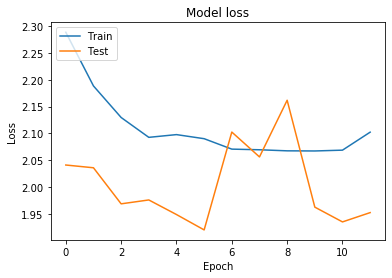

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
_= plt.legend(['Train', 'Test'], loc='upper left')

In [18]:
import gc
# del train_gen
# del valid_gen
# del X_train
# del y_train
# del train_df
gc.collect()


3576

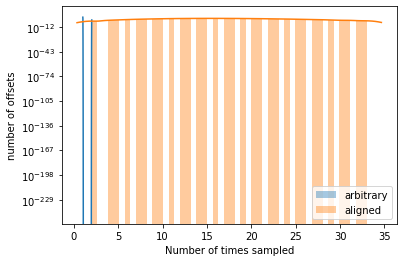

In [57]:
from collections import Counter
tmp = np.array([s for _ in range(12*400) for s in np.random.randint(train_gen.segments[0][0] + train_gen.ts_length, train_gen.segments[-1][1], size=train_gen.batch_size)])
sns.distplot(np.array(list(Counter(tmp).values())))
tmp = tmp//25000 * 25000
sns.distplot(np.array(list(Counter(tmp).values())))
plt.yscale('log')
plt.xlabel('Number of times sampled')
plt.ylabel('number of offsets')
plt.legend(('arbitrary','aligned'))

[590369628 290110636 518321839 606599209 505383120 604889807 443119890
 306820032 192786405 510300628 532414187 272689753 586836022 378660890
 596750201 510763209 156157280 218211415 563622636 391366433 241934112
 463123662 571148143 437166615 353789356 209945230 201952139 193919127
 242509009 141063857 398560401 583660740 383111296 174996282 357768648
 219273744 510927963 475252013 260987750 325312879 186297720 325752762
 375992113 369791281 357444349 597380094 565132648 253019765 374681323
 181396876 518709395 411360548 382088581 328996382 431215051 374285655
 560481769 179759388 420939617 373804614 569133295 533687771 333589073
 475407093]
[590350000 290100000 518300000 606575000 505375000 604875000 443100000
 306800000 192775000 510300000 532400000 272675000 586825000 378650000
 596750000 510750000 156150000 218200000 563600000 391350000 241925000
 463100000 571125000 437150000 353775000 209925000 201950000 193900000
 242500000 141050000 398550000 583650000 383100000 174975000 3577

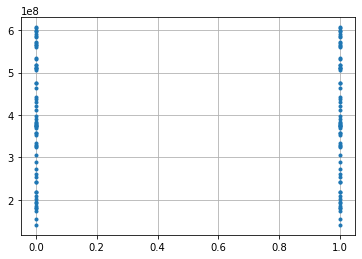

In [39]:
tmp = np.random.randint(train_gen.segments[0][0] + train_gen.ts_length, train_gen.segments[-1][1], size=train_gen.batch_size)
print(tmp)
print(tmp//25000 * 25000)
plt.plot(np.concatenate((np.zeros(len(tmp)),np.ones(len(tmp)))),np.concatenate((tmp,tmp//25000 * 25000)),'.')
plt.grid()

In [19]:
model.save_weights('./trained_model.h5', overwrite=True)

Load and normalize the test data

In [20]:
def load_test(ts_length = 150000):
    base_dir = DATA/'test'
    test_files = [f for f in listdir(base_dir) if isfile(join(base_dir, f))]

    ts = np.empty([len(test_files), ts_length])
    ids = []
    
    i = 0
    for f in tqdm_notebook(test_files):
        ids.append(splitext(f)[0])
        t_df = pd.read_csv(base_dir/f, dtype={"acoustic_data": np.int8})
        ts[i, :] = t_df['acoustic_data'].values
        i = i + 1

    return ts, ids

In [21]:
test_data, test_ids = load_test()

In [22]:
X_test = ((test_data - X_train_mean)/ X_train_std)
X_test = np.expand_dims(X_test, 2)
X_test.shape

(2624, 150000, 1)

Load best model and predict

In [23]:
y_pred = model.predict(X_test)

In [24]:
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred[:, 0]})

In [25]:
submission_df.to_csv("submission.csv", index=False)